In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline


Bad key text.latex.preview in file C:\Users\jonat\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\jonat\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\jonat\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, 

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'Settle Price'}, xlabel='Date'>

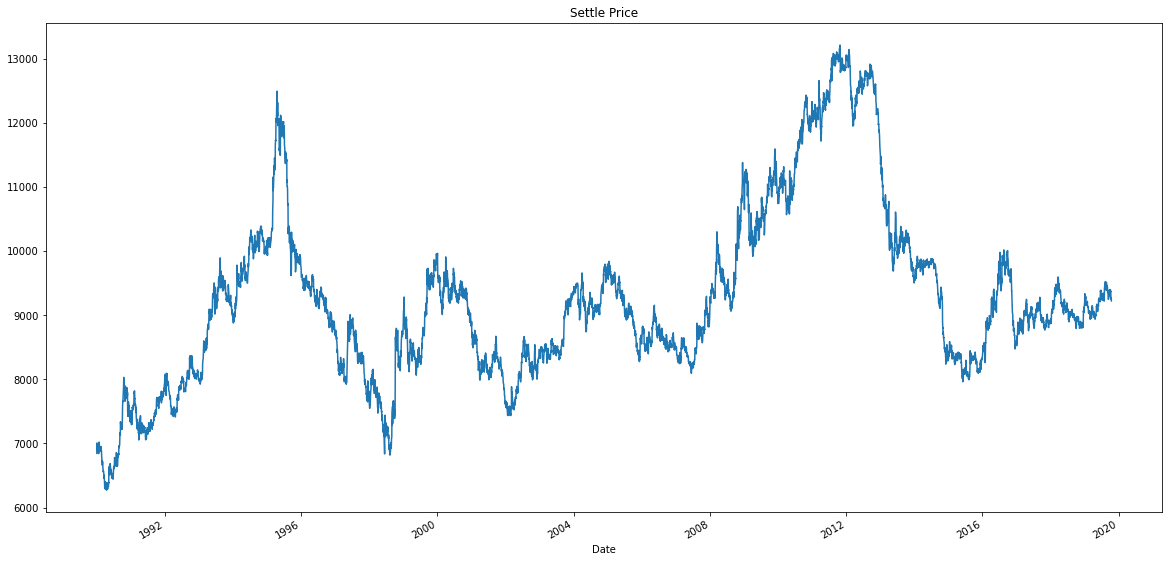

In [4]:
# Plot just the "Settle" column from the dataframe:
# YOUR CODE HERE!
yen_futures['Settle'].plot(figsize=(20, 10), title="Settle Price")

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
# YOUR CODE HERE!
ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [6]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
# YOUR CODE HERE!
yen_futures_settle = yen_futures.drop(columns=['Open', 'High', 'Low', 'Last', 'Change', 'Volume', 'Previous Day Open Interest'])
yen_futures_settle['Noise']=ts_noise
yen_futures_settle['Trend']=ts_trend
yen_futures_settle.head()

,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


<AxesSubplot:title={'center':'Settle Price vs. Trend'}, xlabel='Date'>

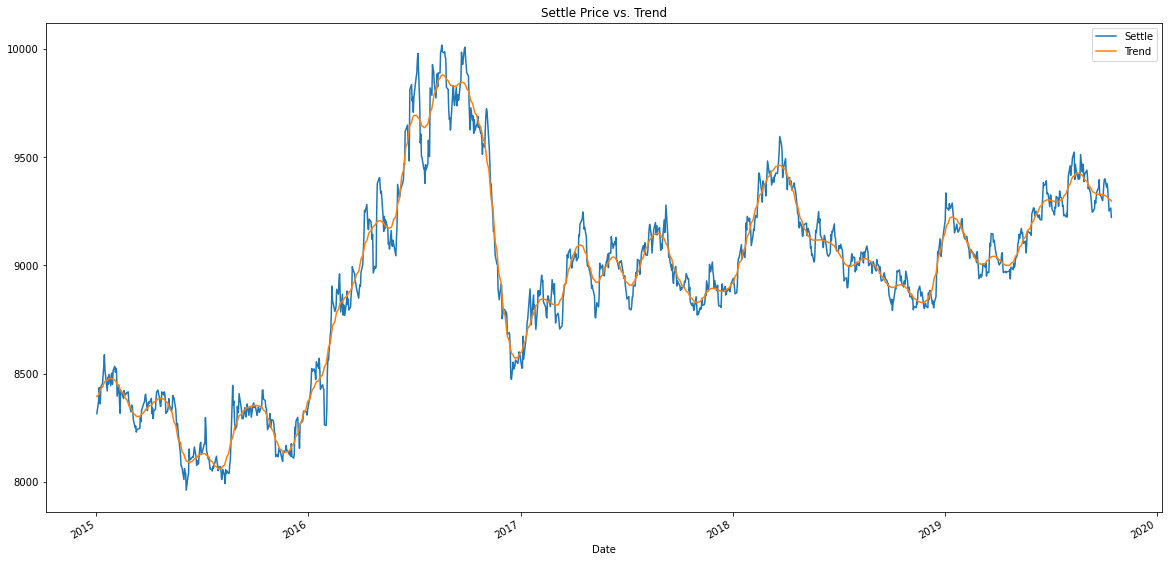

In [7]:
# Plot the Settle Price vs. the Trend for 2015 to the present
# YOUR CODE HERE!
yen_futures_settle.loc['2015':].plot(y=['Settle', 'Trend'], figsize=(20,10), title='Settle Price vs. Trend')

<AxesSubplot:title={'center':'Settle Noise'}, xlabel='Date'>

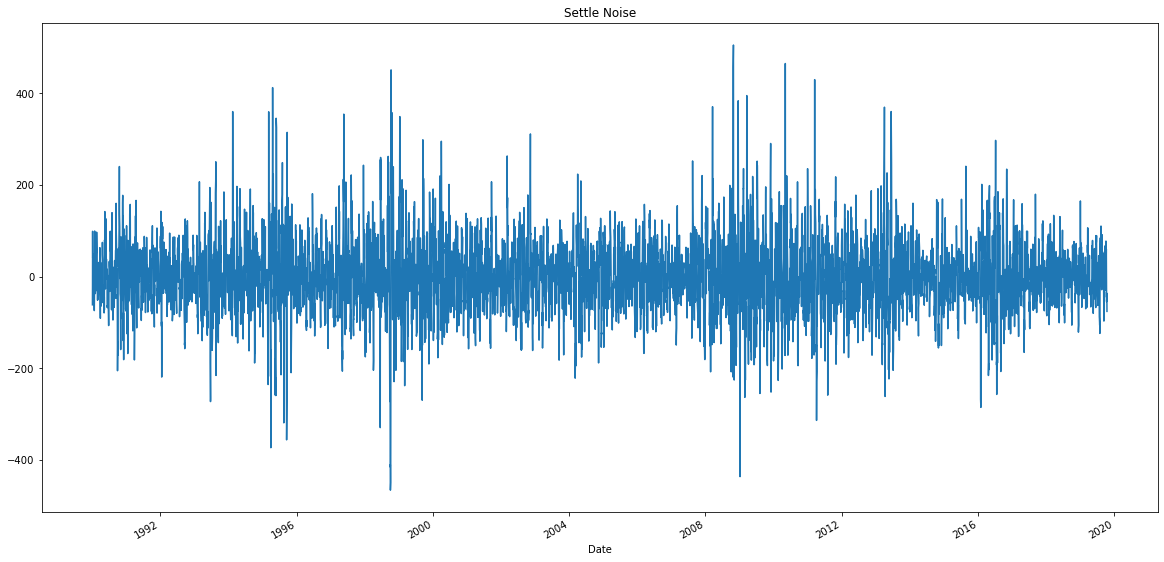

In [8]:
# Plot the Settle Noise
# YOUR CODE HERE!
ts_noise.plot(figsize=(20,10), title='Settle Noise')

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [10]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
# YOUR CODE HERE!
from statsmodels.tsa.arima.model import ARIMA
# Fit the model and assign it to a variable called results
# YOUR CODE HERE!
model = ARIMA(returns.values, order=(2,0,1)) #Difference of 0 makes this an ARMA. Had to use ARIMA import because I was getting errors
results = model.fit()

C:\Users\jonat\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jonat\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [11]:
# Output model summary results:
# YOUR CODE HERE!
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -7894.080
Date:                Fri, 04 Mar 2022   AIC                          15798.159
Time:                        18:16:05   BIC                          15832.782
Sample:                             0   HQIC                         15810.047
                               - 7514                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.774      0.439      -0.010       0.022
ar.L1         -0.0058     19.628     -0.000      1.000     -38.476      38.465
ar.L2         -0.0004      0.229     -0.002      0.999      -0.449       0.448
ma.L1         -0.0058     19.627     -0.000      1.000     -38.475      38.463
sigma2         0.4787      0.004    123.831      0.000       0.471       0.486
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             17209.44
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

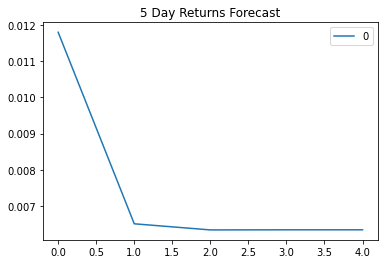

In [12]:
# Plot the 5 Day Returns Forecast
# YOUR CODE HERE!
pd.DataFrame(results.forecast(steps=5)).plot(title="5 Day Returns Forecast")

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!
model = ARIMA(yen_futures.Settle.values, order=(5, 1, 1))
# Fit the model
# YOUR CODE HERE!
results = model.fit()


In [14]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7515
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.789
Date:                Fri, 04 Mar 2022   AIC                          83903.577
Time:                        18:16:06   BIC                          83952.049
Sample:                             0   HQIC                         83920.220
                               - 7515                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0074      1.725     -0.004      0.997      -3.389       3.374
ar.L2         -0.0035      0.027     -0.128      0.898      -0.057       0.050
ar.L3         -0.0137      0.011     -1.197      0.231      -0.036       0.009
ar.L4         -0.0176      0.026     -0.674      0.501      -0.069       0.034
ar.L5         -0.0051      0.031     -0.161      0.872      -0.067       0.057
ma.L1         -0.0076      1.725     -0.004      0.996      -3.389       3.373
sigma2      4132.5390     33.382    123.796      0.000    4067.112    4197.966
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13716.71
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:title={'center':'5 Day Futures Price Forecast'}>

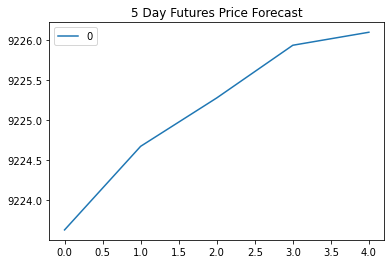

In [15]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!
pd.DataFrame(results.forecast(steps=5)).plot(title="5 Day Futures Price Forecast")

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [16]:
import arch 
from arch import arch_model

In [17]:
# Estimate a GARCH model:
# YOUR CODE HERE!
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
# YOUR CODE HERE!
garch_results = model.fit(disp='off')

In [18]:
# Summarize the model results
# YOUR CODE HERE!
garch_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Fri, Mar 04 2022   Df Residuals:                     7514
Time:                        18:16:07   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.707e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [19]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [20]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
# YOUR CODE HERE!
forecasts = garch_results.forecast(start='2019-10-15', horizon=forecast_horizon, reindex=True)
forecasts

In [21]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434032,7.475729,7.516851,7.55741,7.597418


In [22]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434032
h.2,7.475729
h.3,7.516851
h.4,7.557410
h.5,7.597418


<AxesSubplot:>

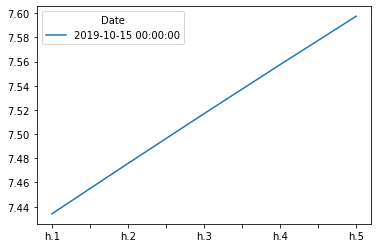

In [23]:
# Plot the final forecast
# YOUR CODE HERE!
final.plot()

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

# I would not buy the Yen right now because the volatility, or the risk, of the Yen is going to increase steadily over the next five days
# I would be confident in using these models for trading